# XGB model hyperparameters tuning

- `xgboost.cv`
- Comparing the optimal candidates by test set, using the g-research weighted correlation metrics.

## 1. cv tuned model folders

- `model_nof_{version number}`

In [2]:
import os
sorted([int(s.split('_')[-1]) for s in os.listdir('./trainedXGB/') if 'model_nof' in s])[-4:]

[22, 23, 24, 25]

## 2. organized data set  

- new_data.ftr

In [3]:
import pandas as pd
import gc
df_train = pd.read_feather('./data'+'/new_data.ftr').drop('index',axis=1)
df_train.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Weight,lr_15,Mkt_lrt_15,Crypto_Index
0,1509927300,0,2.0,1.5,1.5,1.5,1.5,10.83,3.5,0.0,4.304065,0.0,0.002163,7121.328991
1,1509927360,0,2.0,1.5,1.5,1.5,1.5,10.83,3.5,0.0,4.304065,0.0,0.002175,3189.309124
2,1509927420,0,2.0,1.5,1.5,1.5,1.5,10.83,3.5,0.0,4.304065,0.0,0.001814,3189.265156
3,1509927480,0,2.0,1.5,1.5,1.5,1.5,10.83,3.5,0.0,4.304065,0.0,0.000701,7100.364247
4,1509927540,0,2.0,1.5,1.5,1.5,1.5,10.83,3.5,0.0,4.304065,0.0,0.003003,7123.915553


## 3. Features

In [4]:
from script.XGB.xgbmodel import get_features
pd.options.mode.chained_assignment = None  # default='warn'
#df_train.groupby('Asset_ID').apply(lambda x: get_features(x, lagfeatures=True))

## 4. Test set range

- train set range is after `df_train['timestamp'].quantile(0.5)`
- test set

In [5]:
df_train['timestamp'].quantile(0.5)

1581021420.0

In [6]:
pd.to_datetime(df_train['timestamp'].quantile(0.5),unit="s",
               infer_datetime_format=True)

Timestamp('2020-02-06 20:37:00')

In [7]:
int(pd.Timestamp('2021-09-21T00:00:00').timestamp())

1632182400

In [8]:
import datetime
import time

#test_days= 30*3
def make_testset(df_train, start,end):
    dd = df_train[(start<=df_train['timestamp']) & (df_train['timestamp']<=end)].copy()
    ###consistent timestamp for all 14 assets
    dd = dd.sort_values('timestamp').set_index("timestamp").sort_index()
    ind = dd.index.unique()
    def reindex(df):
        df = df.reindex(range(ind[0],ind[-1]+60,60),method='nearest')
        df = df.fillna(method="ffill").fillna(method="bfill")
        return df
    dd = dd.groupby('Asset_ID').apply(reindex).reset_index(0, drop=True).sort_index()
    ###add features
    dd = dd.groupby('Asset_ID').apply(lambda x: get_features(x, lagfeatures=True))
    dd.dropna(axis = 0, inplace= True)
    return dd.reset_index()
    
################################################out-train test
test_end= df_train['timestamp'].max()
test_start= df_train['timestamp'].quantile(0.95)
df_test = make_testset(df_train, test_start,test_end)

#############################################in-train test same as API
test_end2= 1632182400
test_start2= 1623542400 - 60*64
df_test2 = make_testset(df_train, test_start2,test_end2)


In [9]:
del df_train
gc.collect()
df_test.tail()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,...,PPO,CMO,MIDPOINT,TRENDLINE,rsi_15,macd_15_30,macd_signal,macd_hist,close_bollinger_up_15,close_bollinger_down_15
1285237,1637970180,9,155.0,194.899994,195.500000,194.899994,195.199997,755.846008,195.199997,0.000064,...,-0.180967,-32.381156,196.000000,196.821859,38.268429,-0.369550,-0.342710,-0.026840,1.877502,0.677494
1285238,1637970180,10,20.0,3105.000000,3107.000000,3104.000000,3105.000000,0.603900,3105.500000,-0.004860,...,-0.199612,-32.950710,3120.500000,3134.684291,34.692924,-6.038245,-5.349773,-0.688472,31.190608,6.657275
1285239,1637970180,11,12.0,223.899994,224.100006,223.899994,223.899994,12.926000,224.000000,0.012574,...,-0.078031,-24.677380,225.150002,225.530036,38.935561,-0.187040,-0.124157,-0.062883,2.827590,1.067583
1285240,1637970180,12,105.0,0.327600,0.328500,0.327400,0.327500,102431.000000,0.327950,0.002122,...,-0.115673,-25.639094,0.328850,0.330000,37.681768,-0.000622,-0.000602,-0.000020,0.003169,0.001196
1285241,1637970180,13,105.0,0.092030,0.092180,0.092010,0.092040,664579.312500,0.092095,0.000705,...,-0.176501,-31.636466,0.092410,0.092731,35.011971,-0.000133,-0.000114,-0.000019,0.000789,0.000185


## Performance on test set

In [10]:
import xgboost as xgb
from os.path import exists
from script.data_target import ResidualizeMarket
#ResidualizeMarket(df=df_test, mktColumn='Close', window=15)

ASSET_DETAILS_CSV = './data/asset_details.csv'
df_asset_details = pd.read_csv(ASSET_DETAILS_CSV).sort_values("Asset_ID")

def model_reload_train(param_version):
    models = {}
    for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
        model_file = f"./trainedXGB/model_nof_{param_version}/model_{asset_id}.json"
        if exists(model_file):
            model = xgb.Booster()
            model.load_model(model_file)
            models[asset_id] = model
    return models

In [11]:
from script.weighted_corr_metrics import weighted_correlation

result = []
result2 = []
models = {}
for version_num in sorted([int(s.split('_')[-1]) for s in os.listdir('./trainedXGB/') if 'model_nof' in s])[-4:]:
    models[version_num] =model_reload_train(param_version= version_num)
    result_id=[]
    result_id2=[]
    for id in range(0,14):
        model = models[version_num][id]
        x = df_test[df_test['Asset_ID']==id]
        x['Pred'] = model.predict(xgb.DMatrix(x[model.feature_names]))
        result_id.append(x[['timestamp','Asset_ID','Weight','Target','Pred']])
        x2 = df_test2[df_test2['Asset_ID']==id]
        x2['Pred2'] = model.predict(xgb.DMatrix(x2[model.feature_names]))
        result_id2.append(x2[['timestamp','Asset_ID','Weight','Target','Pred2']])
        
    result.append(pd.concat(result_id, axis=0))
    result2.append(pd.concat(result_id2, axis=0))
    score=weighted_correlation(a=result[-1]['Target'], 
                     b=result[-1]['Pred'], 
                     weights=result[-1]['Weight'])
    score2=weighted_correlation(a=result2[-1]['Target'], 
                     b=result2[-1]['Pred2'], 
                     weights=result2[-1]['Weight'])
    #print(f"features: {models[0].feature_names}")
    print(f'model_nof_{version_num} finished. Out-train-score:{score}, In-train-score:{score2}')

model_nof_22 finished. Out-train-score:0.46670865828146596, In-train-score:0.4779640497611065
model_nof_23 finished. Out-train-score:0.40259248301068185, In-train-score:0.3942663207618654
model_nof_24 finished. Out-train-score:0.012649871918673738, In-train-score:0.3919449710254553
model_nof_25 finished. Out-train-score:0.01264923694297062, In-train-score:0.3124282126206829


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

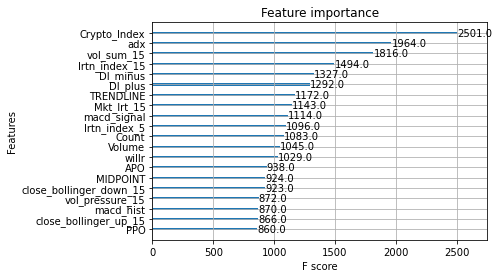

In [17]:
xgb.plot_importance(models[22][0], max_num_features=20)

In [15]:
models[23][0].feature_names

['Count',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'VWAP',
 'lr_15',
 'Mkt_lrt_15',
 'Crypto_Index',
 'Upper_Shadow',
 'Lower_Shadow',
 'lrtn_close_5',
 'lrtn_close_15',
 'lrtn_index_5',
 'lrtn_index_15',
 'vol_sum_15',
 'vol_delta_15',
 'vol_pressure_1',
 'vol_pressure_15',
 'willr',
 'adx',
 'DI_plus',
 'DI_minus',
 'ROCP',
 'momentam',
 'APO',
 'PPO',
 'CMO',
 'MIDPOINT',
 'TRENDLINE',
 'rsi_15',
 'macd_15_30',
 'macd_signal',
 'macd_hist',
 'close_bollinger_up_15',
 'close_bollinger_down_15']